This notebook requires you pip install mfdfa. Documentation can be found at [https://github.com/LRydin/MFDFA/blob/master/README.md]().

It also relies on the files on the data/archive/*.wav files, so if those are moved or renamed parts of this may break.

In [2]:
import numpy as np
import MFDFA as MFDFA
import emd

A copied section from DT's FFT lab from last semester, just for convenience loading/working with files.

In [3]:
import time
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy.fftpack import fft, ifft, fft2, ifft2
from scipy.signal import fftconvolve
import numpy as np
import IPython
import imageio
import pywt

In [13]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

In [4]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        # store attributes
        self.rate = rate
        self.samples = samples

    # Problems 1.1 and 1.7
    def plot(self, freq=False):
        """Plot the graph of the sound wave (time versus amplitude).
        If freq=True, plot the sound wave in Frequency domain (magnitude vs frequency)."""
        # add subplot only if freq=True the amplitude per time
        if freq:
            plt.subplot(121)

        # find the maximum time and the domain of the samples
        max_time = len(self.samples) / self.rate
        domain = np.linspace(0, max_time, len(self.samples))

        # plot the samples
        plt.plot(domain, self.samples, "b-")
        plt.title("Time Vs Amplitude")
        plt.xlim(-max_time / 100, 1.01 * max_time)
        plt.xlabel("Time (s)")
        plt.ylim(-32768, 32768)
        plt.ylabel("Samples")

        if freq:  # plot magnitude of frequencies
            # find the domain and dft
            plt.subplot(122)
            domain = np.arange(len(self.samples)) / len(self.samples) * self.rate
            dft = fft(self.samples)

            # plot the dft
            plt.plot(domain, np.abs(dft), "b-")
            plt.title("Frequency vs Magnitude")
            plt.xlabel("Frequency (Hz)")
            plt.xlim(-200, 20200)
            plt.ylabel("Magnitude")
            plt.ylim(0, 1.01*np.max(np.abs(dft)))
            plt.tight_layout()

        # show the plot
        plt.show()

    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples.
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
            force (bool): Whether to rescale the samples, if type is np.int16
        """
        # rescale samples, if necessary
        samples = self.samples
        if not type(samples[0]) is np.int16 or force:
            # take only real part, if necessary
            if type(samples[0]) is complex:
                samples = np.array([x.real for x in samples])
            samples = np.int16(samples / np.max(samples) * 32767)

        # write to the file
        wavfile.write(filename, self.rate, samples)

    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.

        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        # ensure the two objects are SoundWaves of the same length
        if type(other) is not SoundWave:
            raise ValueError(f"Addition not defined between SoundWave and object of type {type(other)}")
        if len(self.samples) != len(other.samples):
            raise ValueError("SoundWaves must be the same length")

        # return the element wise addition of the samples
        return SoundWave(self.rate, self.samples + other.samples)


    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        # ensure the two objects are SoundWaves of the same length
        if type(other) is not SoundWave:
            raise ValueError(f"Right shift not defined between SoundWave and object of type {type(other)}")
        if self.rate != other.rate:
            raise ValueError("SoundWaves must have the same rate")

        # append the other's samples and return
        return SoundWave(self.rate, np.append(self.samples, other.samples))

    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.

        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.

        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        # raise relevant errors
        if type(other) is not SoundWave:
            raise ValueError("Cannot convolve object of type SoundWave with object of type " + str(type(other)))
        if self.rate != other.rate:
            raise ValueError("Cannot convolve SoundWaves with different rates")

        # make other and self same length
        a_samples = self.samples
        b_samples = other.samples
        if len(a_samples) < len(b_samples):
            a_samples = np.pad(a_samples, (0, len(b_samples) - len(a_samples)), 'constant', constant_values=(0, 0))
        elif len(b_samples) < len(a_samples):
            b_samples = np.pad(b_samples, (0, len(a_samples) - len(b_samples)), 'constant', constant_values=(0, 0))

        # convolve samples and return new SoundWave
        new_samples = ifft(fft(a_samples) * fft(b_samples))
        return SoundWave(self.rate, new_samples)

    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.

        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.

        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        # raise relevant errors
        if type(other) is not SoundWave:
            raise ValueError("Cannot convolve object of type SoundWave with object of type " + str(type(other)))
        if self.rate != other.rate:
            raise ValueError("Cannot convolve SoundWaves with different rates")

        # make other and self same length
        a_samples = self.samples
        b_samples = other.samples
        min_size = len(a_samples) + len(b_samples) - 1
        size = int(2 ** np.ceil(np.log(min_size) / np.log(2)))
        a_samples = np.pad(a_samples, (0, size - len(a_samples)), 'constant', constant_values=(0, 0))
        b_samples = np.pad(b_samples, (0, size - len(b_samples)), 'constant', constant_values=(0, 0))

        # convolve samples and return new SoundWave
        new_samples = ifft(fft(a_samples) * fft(b_samples))
        return SoundWave(self.rate, new_samples[:min_size])

    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT.

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher bound of the frequency range to zero out.
        """
        n = len(self.samples)
        k_low = int(low_freq * n / self.rate)
        k_high = int(high_freq * n / self.rate)
        DFT = fft(self.samples)
        DFT[k_low:k_high] = 0
        DFT[n - k_high:n - k_low] = 0
        new_samples = ifft(DFT)
        return SoundWave(rate, new_samples)

### Problem 1.1

- Implement `SoundWave.__init__()`.
- Implement `SoundWave.plot()`.
- Use the `scipy.io.wavfile.read()` and the `SoundWave` class to plot `tada.wav`.

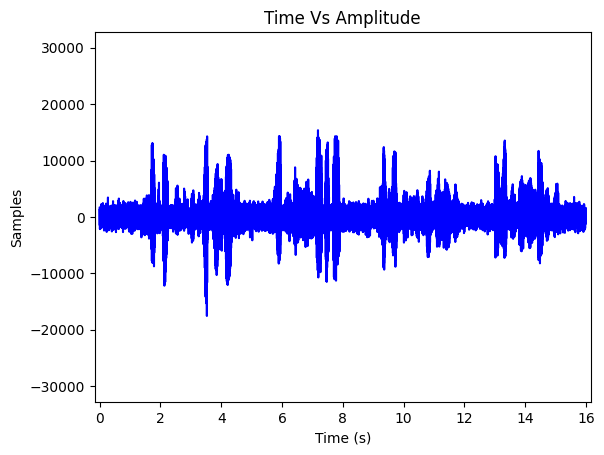

In [11]:
rate, sample = wavfile.read("data/archive/car.wav")
tada = SoundWave(rate, sample)
tada.plot()

# Show original Audio
IPython.display.Audio(filename="data/archive/car.wav")

## Adapting for use with local files, and using MFDFA. Much of this code is copied from the [example in the docs](https://mfdfa.readthedocs.io/en/latest/1dprocess.html)

To now utilise the MFDFA, we take this exemplary process and run the (multifractal) detrended fluctuation analysis. For now lets consider only the monofractal case, so we need only $q=2$.

In [16]:
# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100, dtype=int))

# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag, dfa = MFDFA.MFDFA(sample, lag = lag, q = q, order = order)

Now we need to visualise the results, which can be understood in a log-log scale. To find H we need to fit a line to the results in the log-log plot

Estimated H = 0.854


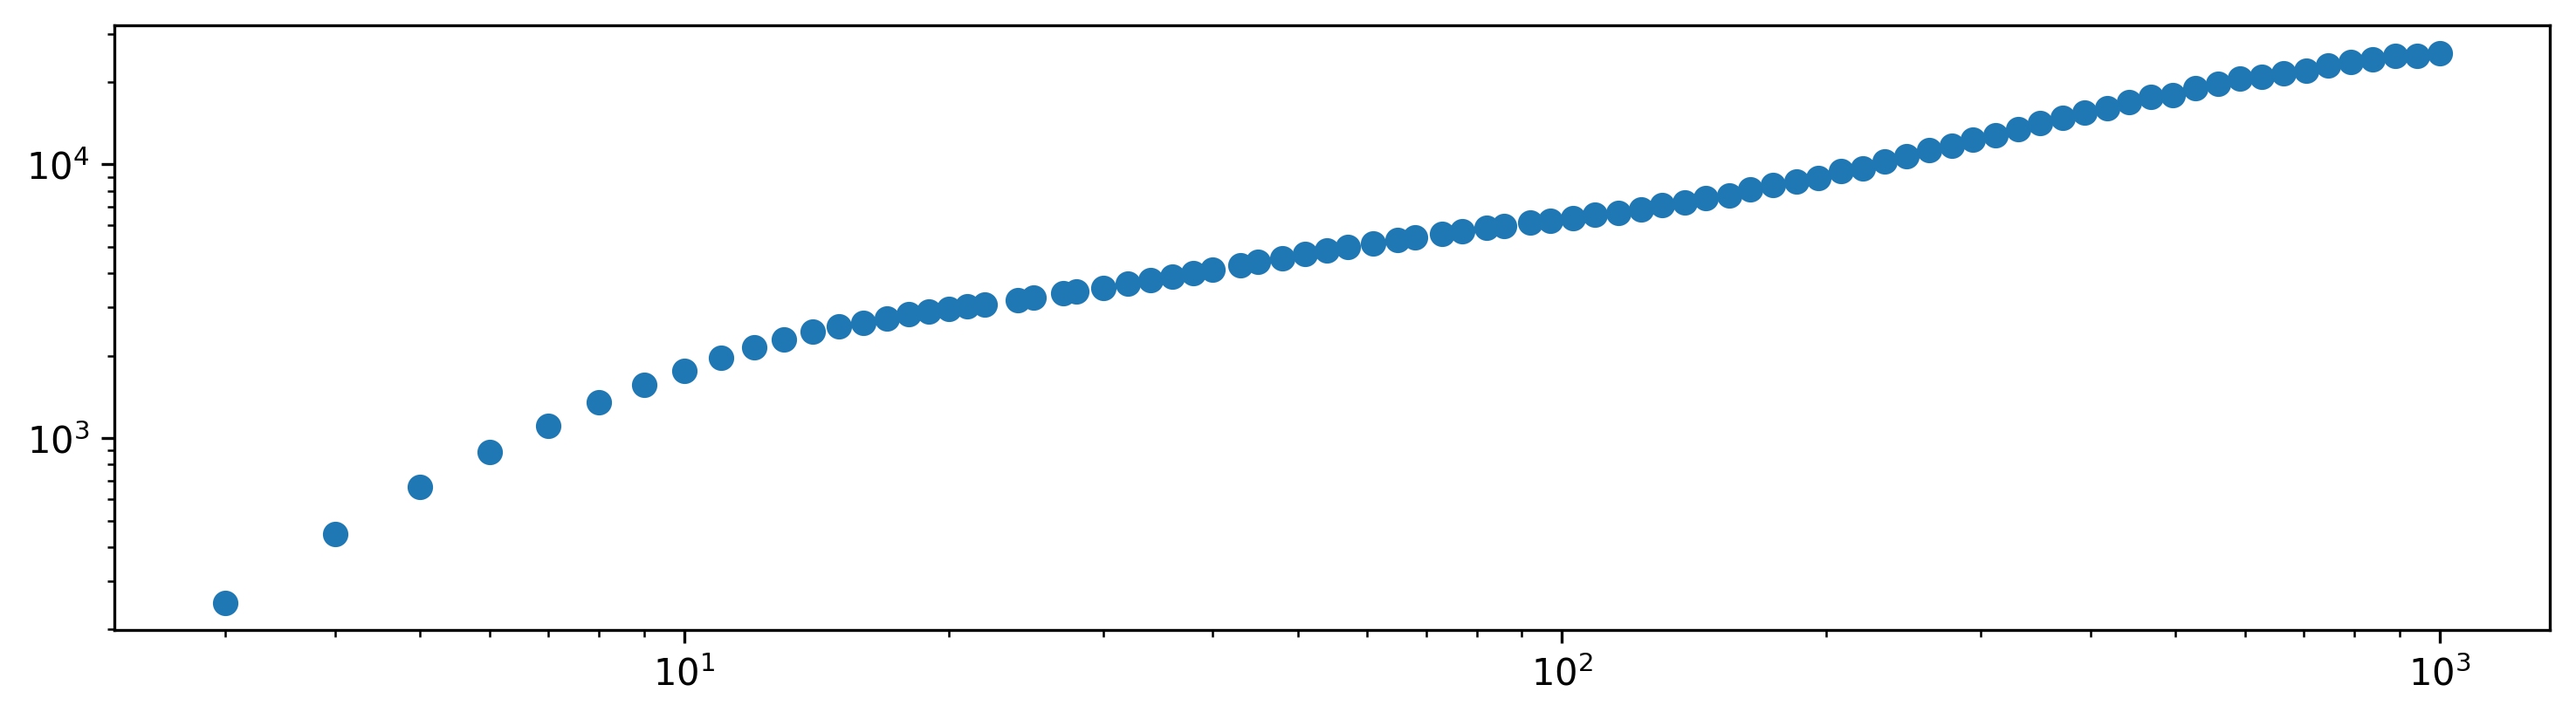

In [18]:
# To uncover the Hurst index, lets get some log-log plots
plt.loglog(lag, dfa, 'o', label='fOU: MFDFA q=2')

# And now we need to fit the line to find the slope
# in a double logaritmic scales, i.e., you need to
# fit the logs of the results
H_hat = np.polyfit(np.log(lag)[4:20],np.log(dfa[4:20]),1)[0]

print('Estimated H = '+'{:.3f}'.format(H_hat[0]))


# Now what you should obtain is: slope = H + 1

## From here on we follow the steps as outlined in [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8367589/](). See [Figure 3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8367589/figure/fig3/) for outline.

After a closer look, I'm not sure MFDFA is going to be a quick solution. Mainly, none of the algorithms or papers I can find seem to be already implemented. Additionally, the above ncbi paper combines mfdfa and emd, and seems to require a human looking at things to interpret the mfdfa. as such I am switching to emd as implemented in [https://emd.readthedocs.io/en/stable/]().

## Using the EMD library

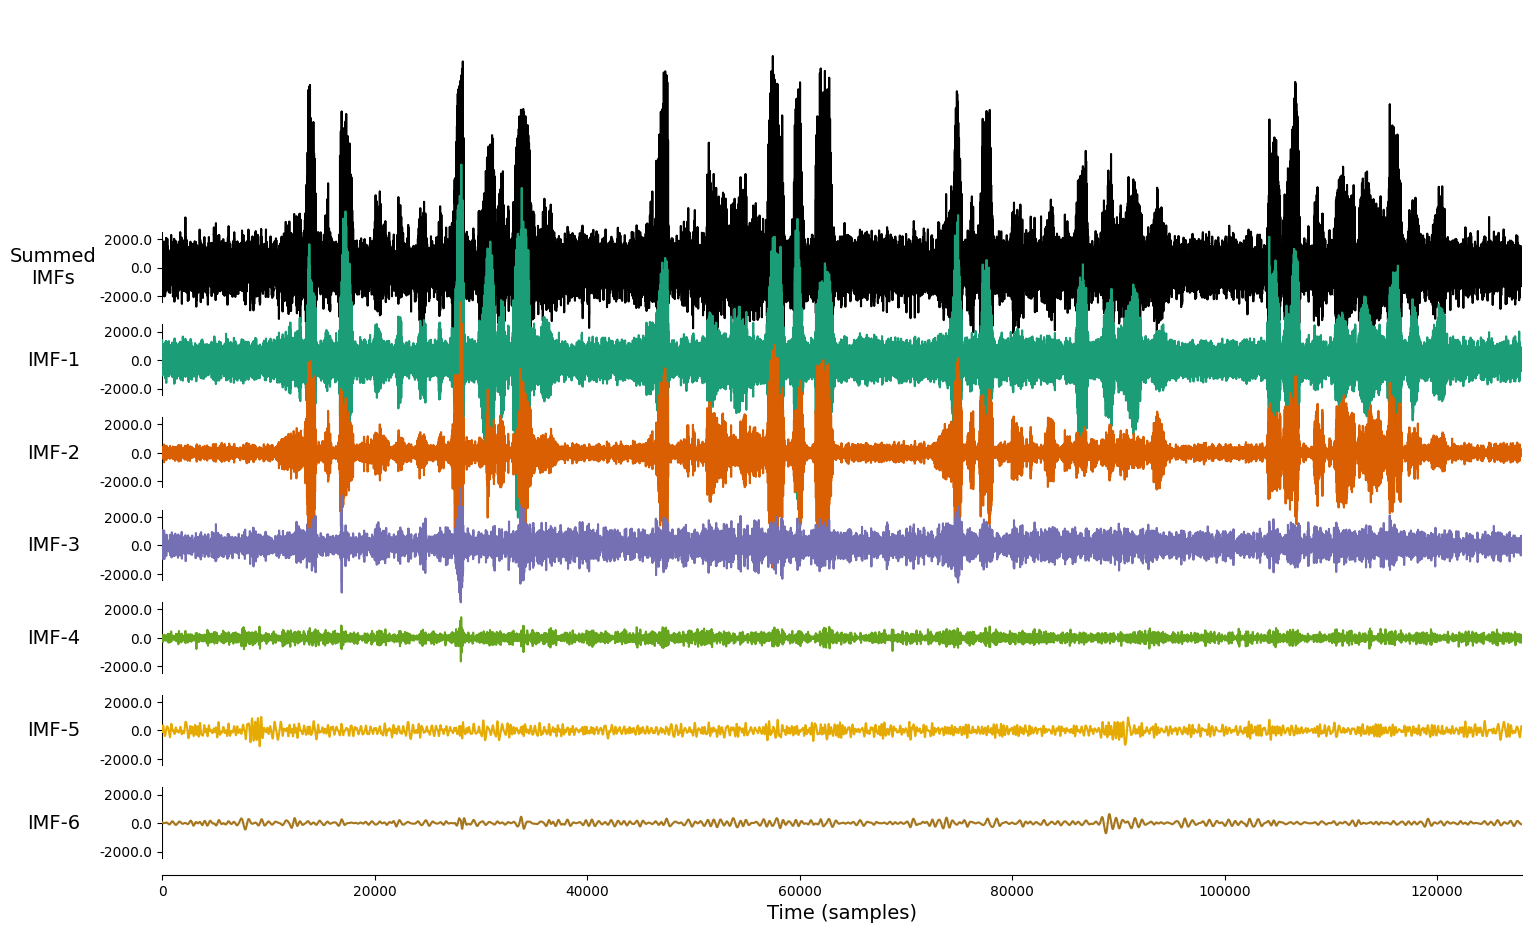

In [14]:
# sifting basically is the process for finding the Intrinsic Mode Functions (IMFs) that sum to the original image, similar to the wavelet decompositions we did for class.
imf = emd.sift.iterated_mask_sift(sample)

# plot imfs
emd.plotting.plot_imfs(imf)
plt.show()

IPython.display.Audio(data=imf[:,0], rate=rate)

In [18]:
print("IMF 2")
IPython.display.Audio(data=imf[:,1], rate=rate)

IMF 2


Ensemble sifting

IMF 1


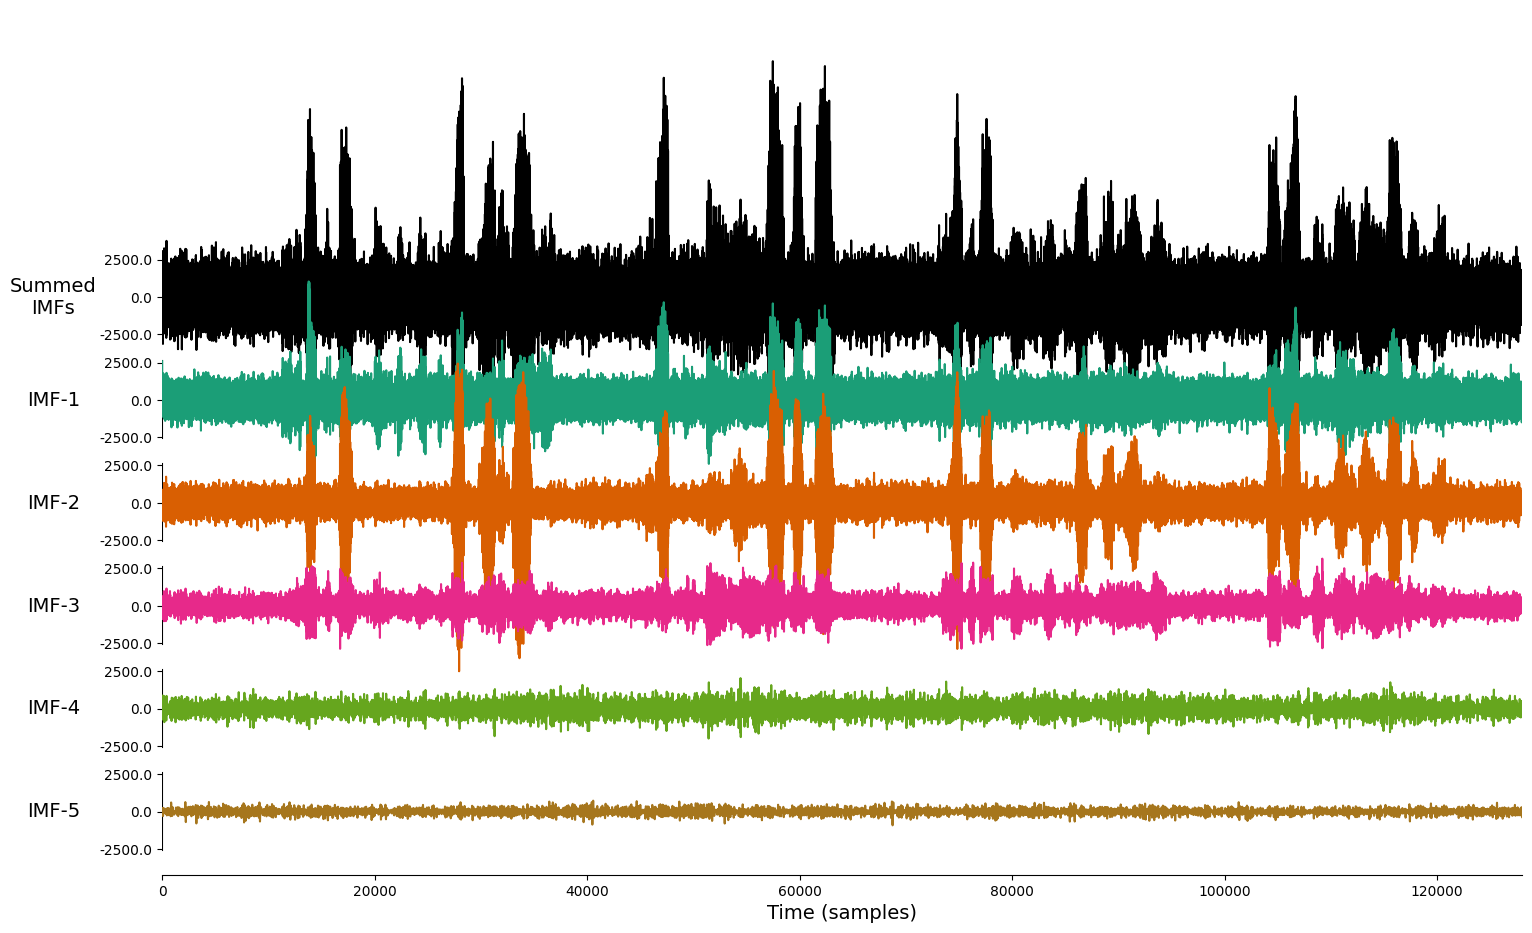

In [21]:
imf_opts = {'sd_thresh': 0.05}
imf = emd.sift.ensemble_sift(sample, max_imfs=5, nensembles=24, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)
print("IMF 1")
IPython.display.Audio(data=imf[:,0], rate=rate)

In [22]:
print("IMF 2")
IPython.display.Audio(data=imf[:,1], rate=rate)

IMF 2


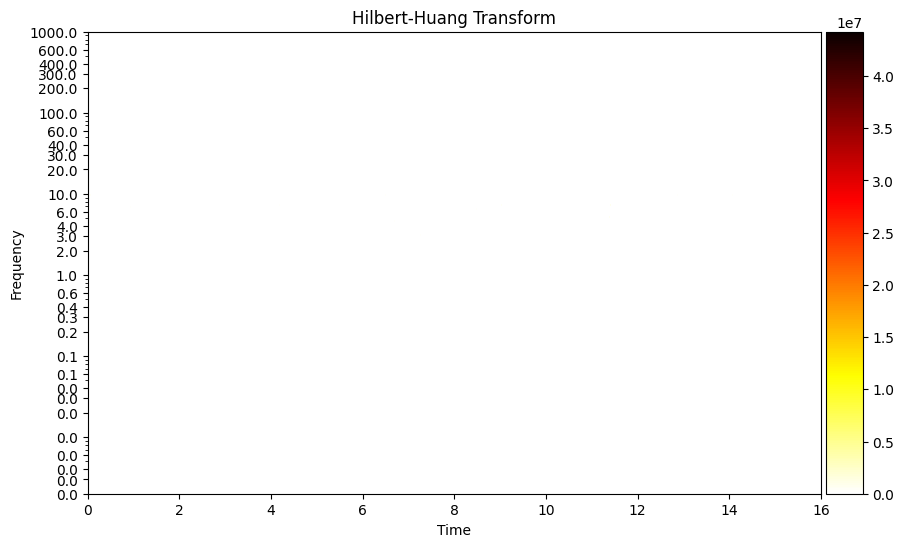

In [20]:
# from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method. Don't know what these are used for yet
IP, IF, IA = emd.spectra.frequency_transform(imf, rate, 'hilbert')

# compute the Hilbert-Huang spectrum
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

# plot Hilbert-Huang transform of the imfs
time_vect = np.linspace(0, len(sample)/rate, len(sample))
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               time_lims=(time_vect[0], time_vect[-1]), freq_lims=(0.001, 1500),
                               fig=fig, log_y=True)
plt.show()